In [1]:
from __future__ import print_function
import sys
import numpy as np
import pandas as pd
pd.options.display.max_rows = 30
import matplotlib.pyplot as plt
%matplotlib notebook
import gvar as gv
import fkfpi_lib as flib
print("python version:", sys.version)
print("pandas version:", pd.__version__)
print("numpy  version:", np.__version__)
print("gvar   version:", gv.__version__)

python version: 2.7.14 (default, Jan  6 2018, 12:15:00) 
[GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.39.2)]
pandas version: 0.20.3
numpy  version: 1.14.2
gvar   version: 8.3.6


In [2]:
switches = dict()
switches['ensemble'] = [
    #'a15m400','a12m400','a09m400',
    #'a15m350','a12m350','a09m350',
    'a15m310','a12m310','a09m310',
    'a15m220','a12m220','a09m220','a12m220S','a12m220L',
    'a12m130']
switches['ansatz'] = dict()
switches['ansatz']['FV'] = True # True turns on NLO FV correction
switches['ansatz']['type'] = 'xpt' # Type of fit: 'xpt' or 'MA'
switches['ansatz']['a2dm'] = 'individual' # avg or individual
switches['scale'] = 'PK' # PP, PK, KK, LamChi = 4 * pi * sqrt(FA * FB)

In [3]:
# Set priors for Xpt
priors = dict()
priors['L5'] = gv.gvar(0.0, 1.0)
priors['s4'] = gv.gvar(0.0, 1.0)
priors['c4'] = gv.gvar(0.0, 1.0)
priors['d4'] = gv.gvar(0.0, 1.0)
priors['e4'] = gv.gvar(0.0, 1.0)
priors['s6'] = gv.gvar(0.0, 1.0)
priors['sc6'] = gv.gvar(0.0, 1.0)
priors['sd6'] = gv.gvar(0.0, 1.0)
priors['se6'] = gv.gvar(0.0, 1.0)
# Physical parameters from PDG
phys_p = dict()
# http://pdg.lbl.gov/2016/tables/rpp2016-tab-mesons-light.pdf
phys_p['mpi'] = gv.gvar(134.8, 0.3) #FLAG 2017 (16)
phys_p['mka'] = gv.gvar(494.2 , 0.3) #FLAG 2017 (16)
phys_p['F0'] = gv.gvar(80,20) #FLAG use of F0 in SU(2) correction for FK/Fpi
phys_p['meta'] = gv.gvar(547.862,0.017) #PDG
# http://pdg.lbl.gov/2015/reviews/rpp2015-rev-pseudoscalar-meson-decay-cons.pdf
phys_p['Fpi'] = gv.gvar(130.2/np.sqrt(2), 1.7/np.sqrt(2)) #PDG fpi+ eq(16)
phys_p['Fka'] = gv.gvar(155.6/np.sqrt(2), 0.4/np.sqrt(2)) #PDG fK++ eq(16)
if switches['scale'] == 'PK':
    phys_p['Lchi'] = 4*np.pi*np.sqrt(phys_p['Fpi']*phys_p['Fka'])
elif switches['scale'] == 'PP':
    phys_p['Lchi'] = 4*np.pi*phys_p['Fpi']
elif switches['scale'] == 'KK':
    phys_p['Lchi'] = 4*np.pi*phys_p['Fka']
phys_p['aw0'] = 0
# FLAG FK/Fpi
flag_FKFpi = gv.gvar(1.1933, 0.0029)

In [4]:
data = pd.read_csv('./github_fkfpi_v1.csv')
hisq_params = pd.read_csv('./hisq_params.csv')
mixed_params = pd.read_csv('./github_mixed_v1.csv')
data.groupby('ensemble').describe()

e0_etas                                          \
                               count      mean       std       min       25%   
ensemble                                                                       
l1648f211b580m013m065m838     5001.0  0.518749  0.000165  0.518051  0.518638   
l2448f211b580m0064m0640m828   5001.0  0.514945  0.000131  0.514495  0.514858   
l2464f211b600m00507m0507m628  5001.0  0.415765  0.000143  0.415263  0.415669   
l2464f211b600m0102m0509m635   5001.0  0.418024  0.000159  0.417320  0.417914   
l2464f211b600m0130m0509m635   5001.0  0.419712  0.000133  0.419273  0.419620   
l2464f211b600m0170m0509m635   5001.0  0.420729  0.000126  0.420219  0.420644   
l3248f211b580m00235m0647m831  5001.0  0.513140  0.000127  0.512665  0.513054   
l3264f211b600m00507m0507m628  5001.0  0.415383  0.000117  0.414853  0.415303   
l3296f211b630m0074m037m440    5001.0  0.311698  0.000106  0.311291  0.311627   
l4064f211b600m00507m0507m628  5001.0  0.415565  0.000120  0.414833  0.415490   
l4864f211b600m00184m0507m628  5001.0  0.414198  0.000105  0.413677  0.414130   
l4896f211b630m00363m0363m430  5001.0  0.309356  0.000074  0.308857  0.309313   

                                                           e0_kaon            \
                                   50%       75%       max   count      mean   
ensemble                                                                       
l1648f211b580m013m065m838     0.518753  0.518861  0.519377  5001.0  0.404589   
l2448f211b580m0064m0640m828   0.514948  0.515033  0.515396  5001.0  0.386898   
l2464f211b600m00507m0507m628  0.415763  0.415860  0.416247  5001.0  0.310440   
l2464f211b600m0102m0509m635   0.418027  0.418133  0.418578  5001.0  0.324153   
l2464f211b600m0130m0509m635   0.419711  0.419802  0.420235  5001.0  0.333086   
l2464f211b600m0170m0509m635   0.420731  0.420815  0.421178  5001.0  0.343404   
l3248f211b580m00235m0647m831  0.513139  0.513224  0.513678  5001.0  0.377956   
l3264f211b600m00507m0507m628  0.415386  0.415460  0.415809  5001.0  0.310021   
l3296f211b630m0074m037m440    0.311699  0.311770  0.312047  5001.0  0.241099   
l4064f211b600m00507m0507m628  0.415569  0.415645  0.415986  5001.0  0.310158   
l4864f211b600m00184m0507m628  0.414199  0.414271  0.414551  5001.0  0.302014   
l4896f211b630m00363m0363m430  0.309358  0.309405  0.309592  5001.0  0.228699   

                                ...     z0p_kaon           z0p_pion            \
                                ...          75%       max    count      mean   
ensemble                        ...                                             
l1648f211b580m013m065m838       ...     0.198529  0.199258   5001.0  0.257676   
l2448f211b580m0064m0640m828     ...     0.200906  0.201728   5001.0  0.317574   
l2464f211b600m00507m0507m628    ...     0.152135  0.152948   5001.0  0.228298   
l2464f211b600m0102m0509m635     ...     0.150452  0.151439   5001.0  0.188272   
l2464f211b600m0130m0509m635     ...     0.151239  0.151848   5001.0  0.179734   
l2464f211b600m0170m0509m635     ...     0.151983  0.152459   5001.0  0.172242   
l3248f211b580m00235m0647m831    ...     0.208497  0.210111   5001.0  0.469283   
l3264f211b600m00507m0507m628    ...     0.151006  0.151818   5001.0  0.225196   
l3296f211b630m0074m037m440      ...     0.101415  0.101947   5001.0  0.122827   
l4064f211b600m00507m0507m628    ...     0.150964  0.151715   5001.0  0.224965   
l4864f211b600m00184m0507m628    ...     0.153730  0.155152   5001.0  0.311812   
l4896f211b630m00363m0363m430    ...     0.099583  0.100041   5001.0  0.140826   

                                                                      \
                                   std       min       25%       50%   
ensemble                                                               
l1648f211b580m013m065m838     0.000673  0.254151  0.257328  0.257753   
l2448f211b580m0064m0640m828   0.000946  0.308784  0.317123  0.317684   
l2464f211b600m00507m0507m628  0.001230  0.218289  0

In [19]:
fmt_data = flib.format_data(switches,data,mixed_params,hisq_params,priors)
#print(fmt_data)
print(fmt_data['y'])

[1.0968(14) 1.1002(15) 1.1093(16) 1.1263(18) 1.1303(21) 1.1433(17)
 1.1329(27) 1.1276(28) 1.1602(35)]


<IPython.core.display.Javascript object>


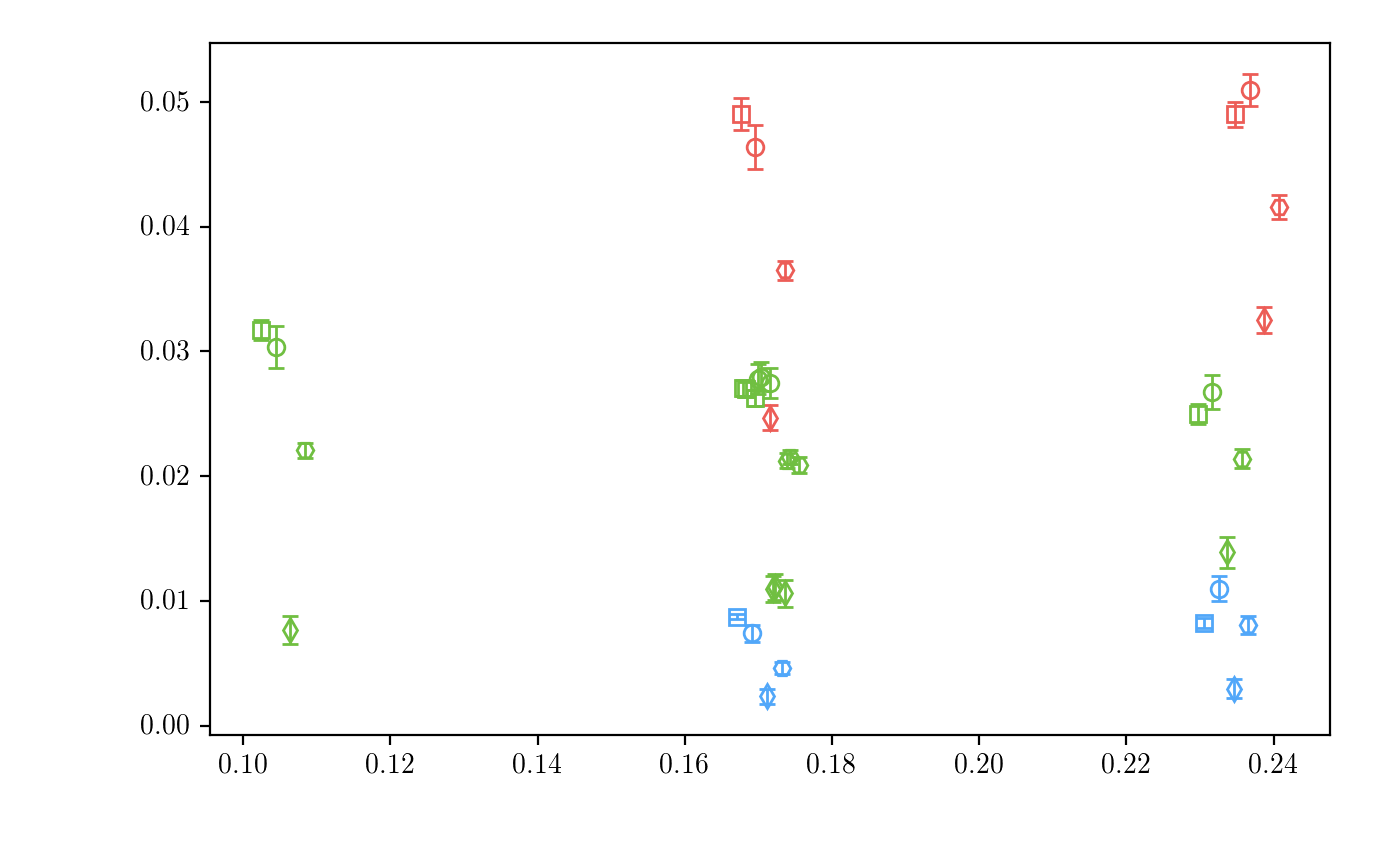

In [6]:
jr = ['ju','ru','js','rs']
mrks = ['s','o','d','H']
shift = [-0.003,-0.001,0.001,0.003]
fig = plt.figure('w0_DMix',figsize=(7,4.326237))
ax = plt.axes([0.15,0.15,0.8,0.8])
colors ={'a15m310':'#ec5d57','a15m220':'#ec5d57','a15m130':'#ec5d57',
        'a12m310':'#70bf41','a12m220':'#70bf41','a12m130':'#70bf41','a12m220S':'#70bf41','a12m220L':'#70bf41',
        'a09m310':'#51a7f9','a09m220':'#51a7f9'}
for i,e in enumerate(switches['ensemble']):
    epi = fmt_data['p']['mpi'][i]/fmt_data['x']['Lchi'][i]
    for j,mix in enumerate(jr):
        wMix = fmt_data['p']['wMix_'+mix][i]
        ax.errorbar(epi.mean+shift[j],wMix.mean,yerr=wMix.sdev,color=colors[e],marker=mrks[j],elinewidth=1,capsize=3,mfc='none')

In [7]:
fit = flib.fit_data(switches,fmt_data,phys_p)
print(fit.format(maxline=True))

Least Square Fit:
  chi2/dof [dof] = 0.52 [9]    Q = 0.86    logGBF = 26.595

Parameters:
            sd6      -0.01 (98)      [     0.0 (1.0) ]  
          mss 0    0.51875 (17)      [  0.51875 (17) ]  
              1    0.41803 (16)      [  0.41803 (16) ]  
              2    0.31169 (10)      [  0.31170 (11) ]  
              3    0.51495 (14)      [  0.51495 (14) ]  
              4    0.41539 (12)      [  0.41539 (12) ]  
              5   0.309359 (70)      [ 0.309358 (70) ]  
              6    0.41574 (14)      [  0.41576 (15) ]  
              7    0.41560 (11)      [  0.41557 (12) ]  
              8    0.41420 (11)      [  0.41420 (11) ]  
          aw0 0    0.88040 (30)      [  0.88040 (30) ]  
              1    0.70360 (50)      [  0.70360 (50) ]  
              2    0.51050 (30)      [  0.51050 (30) ]  
              3    0.88040 (30)      [  0.88040 (30) ]  
              4    0.70360 (50)      [  0.70360 (50) ]  
              5    0.51050 (30)      [  0.51050 (30) ] 

<IPython.core.display.Javascript object>


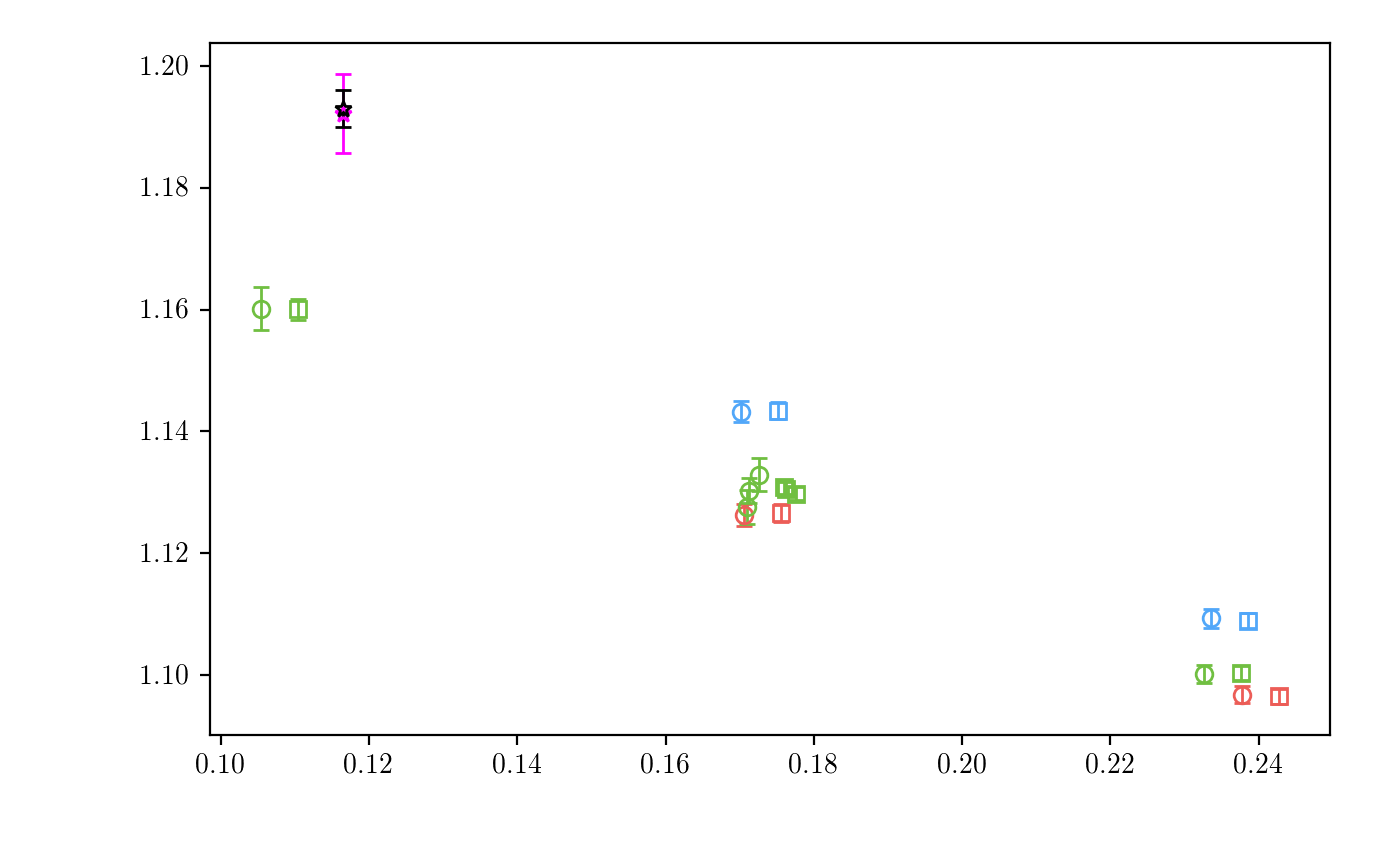

 a15m310 1.0968(14) 1.0965(12)
 a12m310 1.1002(15) 1.1003(11)
 a09m310 1.1093(16) 1.1089(12)
 a15m220 1.1263(18) 1.1266(15)
 a12m220 1.1303(21) 1.1306(11)
 a09m220 1.1433(17) 1.1434(14)
a12m220S 1.1329(27) 1.1298(11)
a12m220L 1.1276(28) 1.1309(11)
 a12m130 1.1602(35) 1.1601(17)
prediction from LQCD
FK / Fpi =  1.1947(66)
FK+/Fpi+ =  1.1922(65)


In [8]:
fig = plt.figure('FK/Fpi',figsize=(7,4.326237))
ax = plt.axes([0.15,0.15,0.8,0.8])
colors ={'a15m400':'#ec5d57','a15m350':'#ec5d57','a15m310':'#ec5d57','a15m220':'#ec5d57','a15m130':'#ec5d57',
        'a12m400':'#70bf41','a12m350':'#70bf41','a12m310':'#70bf41','a12m220':'#70bf41','a12m130':'#70bf41','a12m220S':'#70bf41','a12m220L':'#70bf41',
        'a09m400':'#51a7f9','a09m350':'#51a7f9','a09m310':'#51a7f9','a09m220':'#51a7f9'}
for i,e in enumerate(switches['ensemble']):
    epi = fmt_data['p']['mpi'][i]/fmt_data['x']['Lchi'][i]
    print('%8s %s %s' %(e,str(fmt_data['y'][i]),str(fit.fcn(fit.x,fit.p)[i])))
    ax.errorbar(epi.mean,fmt_data['y'][i].mean,yerr=fmt_data['y'][i].sdev,color=colors[e],marker='o',elinewidth=1,capsize=3,mfc='none')
    ax.errorbar(epi.mean+.005,fit.fcn(fit.x,fit.p)[i].mean,yerr=fit.fcn(fit.x,fit.p)[i].sdev,color=colors[e],marker='s',elinewidth=1,capsize=3,mfc='none')
fkp = flib.fkfpi_phys(phys_p,fit)
ax.errorbar((phys_p['mpi']/(4.*np.pi*phys_p['Fpi'])).mean,fkp.mean,yerr=fkp.sdev,color='magenta',marker='*',elinewidth=1,capsize=3,mfc='none')
ax.errorbar((phys_p['mpi']/(4.*np.pi*phys_p['Fpi'])).mean,1.193,yerr=0.003,color='black',marker='*',elinewidth=1,capsize=3,mfc='none')
plt.savefig('FKFpi_vs_epi.pdf',transparent=True)